✅ Dataset đã tồn tại, bỏ qua bước tải & giải nén.
[CNN] Epoch 1/5 - Loss: 0.5049
[CNN] Epoch 2/5 - Loss: 0.2075
[CNN] Epoch 3/5 - Loss: 0.1034
[CNN] Epoch 4/5 - Loss: 0.0691
[CNN] Epoch 5/5 - Loss: 0.0350

=== Classification Report: CNN ===
              precision    recall  f1-score   support

   Bulbasaur       0.95      0.87      0.91        23
  Charmander       0.89      0.93      0.91        27
      Mewtwo       0.93      0.93      0.93        29
     Pikachu       0.96      0.96      0.96        24
    Squirtle       0.88      0.92      0.90        25

    accuracy                           0.92       128
   macro avg       0.92      0.92      0.92       128
weighted avg       0.92      0.92      0.92       128


=== Classification Report: PCA + Logistic Regression ===
              precision    recall  f1-score   support

   Bulbasaur       0.84      0.70      0.76        23
  Charmander       0.84      1.00      0.92        27
      Mewtwo       0.96      0.90      0.93      

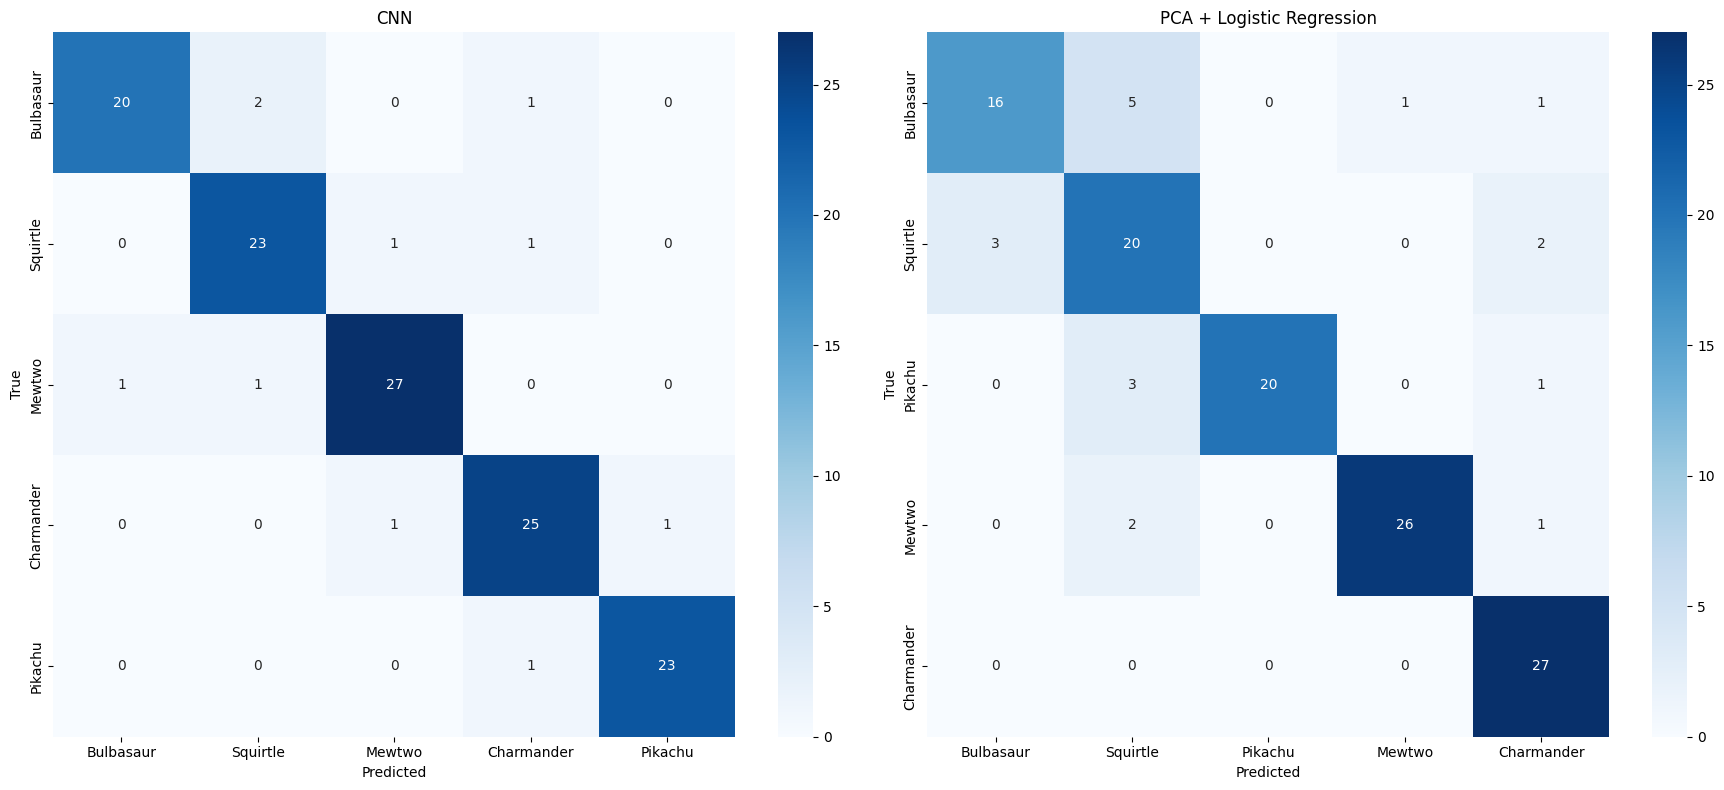


=== So sánh các chỉ số ===
                    Model  Accuracy  Precision  Recall  F1-score
                      CNN    0.9219     0.9238  0.9210    0.9219
PCA + Logistic Regression    0.8516     0.8631  0.8451    0.8484


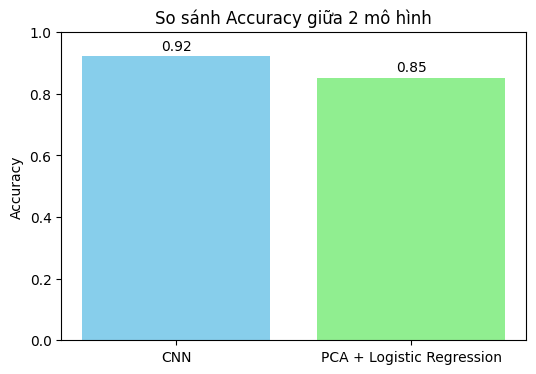

In [8]:
# ========================
# STEP 0: CÀI THƯ VIỆN & ẨN CẢNH BÁO
# ========================
!pip install -q --disable-pip-version-check scikit-learn opencv-python torch torchvision matplotlib seaborn

import warnings, os, random, numpy as np, torch

# Ẩn cảnh báo
warnings.filterwarnings("ignore")

# Chỉ tải & giải nén 1 lần
if not os.path.exists("dataset/train"):
    from google.colab import files
    uploaded = files.upload()  # chọn file zip chứa train/test
    zip_name = list(uploaded.keys())[0]
    # Giải nén & ẩn output
    !unzip -q "$zip_name" -d dataset
else:
    print("✅ Dataset đã tồn tại, bỏ qua bước tải & giải nén.")

# ========================
# FIX RANDOM SEED
# ========================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # nếu dùng multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ========================
# STEP 1: TIỀN XỬ LÝ ẢNH
# ========================
IMG_SIZE = 64
BATCH_SIZE = 32
SHOW_ALL = False  # Nếu True sẽ hiển thị confusion matrix full lớp

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

train_data = datasets.ImageFolder("dataset/train", transform=transform)
test_data = datasets.ImageFolder("dataset/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

class_names = train_data.classes
num_classes = len(class_names)

# ========================
# STEP 2: CNN MODEL
# ========================
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * (IMG_SIZE//4) * (IMG_SIZE//4), 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = SimpleCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# ========================
# STEP 3: TRAIN CNN
# ========================
EPOCHS = 5
for epoch in range(EPOCHS):
    cnn_model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"[CNN] Epoch {epoch+1}/{EPOCHS} - Loss: {running_loss/len(train_loader):.4f}")

# ========================
# STEP 4: DỰ ĐOÁN CNN
# ========================
cnn_model.eval()
y_true_cnn = []
y_pred_cnn = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = cnn_model(images)
        _, preds = torch.max(outputs, 1)
        y_true_cnn.extend(labels.cpu().numpy())
        y_pred_cnn.extend(preds.cpu().numpy())

cnn_report = classification_report(y_true_cnn, y_pred_cnn, target_names=class_names)
print("\n=== Classification Report: CNN ===")
print(cnn_report)

# ========================
# STEP 5: PCA + LOGISTIC REGRESSION
# ========================
def extract_features(loader):
    features = []
    labels = []
    for images, lbls in loader:
        img_np = images.numpy()
        img_np = img_np.reshape(img_np.shape[0], -1)
        features.extend(img_np)
        labels.extend(lbls.numpy())
    return np.array(features), np.array(labels)

X_train, y_train = extract_features(train_loader)
X_test, y_test = extract_features(test_loader)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

lr_model = LogisticRegression(max_iter=500)
lr_model.fit(X_train_pca, y_train)
y_pred_lr = lr_model.predict(X_test_pca)

pca_lr_report = classification_report(y_test, y_pred_lr, target_names=class_names)
print("\n=== Classification Report: PCA + Logistic Regression ===")
print(pca_lr_report)

# ========================
# STEP 6: CONFUSION MATRIX RÚT GỌN & SO SÁNH
# ========================
def plot_confusion_matrix(y_true, y_pred, title, ax):
    cm = confusion_matrix(y_true, y_pred)
    if not SHOW_ALL:
        errors = cm.sum(axis=1) - np.diag(cm)
        top_idx = np.argsort(errors)[::-1][:10]
        cm = cm[top_idx][:, top_idx]
        labels = [class_names[i] for i in top_idx]
    else:
        labels = class_names

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
plot_confusion_matrix(y_true_cnn, y_pred_cnn, "CNN", axes[0])
plot_confusion_matrix(y_test, y_pred_lr, "PCA + Logistic Regression", axes[1])
plt.tight_layout()
plt.show()

# ========================
# STEP 7: SO SÁNH CHỈ SỐ ĐÁNH GIÁ
# ========================
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Tính các chỉ số cho CNN
cnn_acc = accuracy_score(y_true_cnn, y_pred_cnn)
cnn_prec = precision_score(y_true_cnn, y_pred_cnn, average='macro')
cnn_rec = recall_score(y_true_cnn, y_pred_cnn, average='macro')
cnn_f1 = f1_score(y_true_cnn, y_pred_cnn, average='macro')

# Tính các chỉ số cho PCA + LR
pca_lr_acc = accuracy_score(y_test, y_pred_lr)
pca_lr_prec = precision_score(y_test, y_pred_lr, average='macro')
pca_lr_rec = recall_score(y_test, y_pred_lr, average='macro')
pca_lr_f1 = f1_score(y_test, y_pred_lr, average='macro')

# Tạo bảng kết quả
import pandas as pd
metrics_df = pd.DataFrame({
    'Model': ['CNN', 'PCA + Logistic Regression'],
    'Accuracy': [cnn_acc, pca_lr_acc],
    'Precision': [cnn_prec, pca_lr_prec],
    'Recall': [cnn_rec, pca_lr_rec],
    'F1-score': [cnn_f1, pca_lr_f1]
})

print("\n=== So sánh các chỉ số ===")
print(metrics_df.to_string(index=False, float_format="%.4f"))

# Vẽ biểu đồ Accuracy
model_names = ['CNN', 'PCA + Logistic Regression']
accuracies = [cnn_acc, pca_lr_acc]

plt.figure(figsize=(6,4))
bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightgreen'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('So sánh Accuracy giữa 2 mô hình')

# Hiển thị giá trị trên cột
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.2f}', ha='center', fontsize=10)

plt.show()
